![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [67]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


### Preprocesamiento y Análisis Descriptivo

In [68]:
# Factorizar todas las columnas que comienzan con 'M_Camry'
columns_to_factorize = [col for col in data.columns if col.startswith('M_Camry')]
for col in columns_to_factorize:
    data[col] = pd.factorize(data[col])[0]
# Visualización del dataset después de la transformación
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,0,0,0,0
11,13995,2014,39972,0,0,0,1,1,0,0
167,17941,2016,18989,0,0,0,1,0,1,0
225,12493,2014,51330,0,0,0,0,0,0,0
270,7994,2007,116065,0,1,0,1,0,0,0


In [69]:
# Analisis descriptivo
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.951787,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
# Información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  int64
 4   M_Camry4dr   10495 non-null  int64
 5   M_CamryBase  10495 non-null  int64
 6   M_CamryL     10495 non-null  int64
 7   M_CamryLE    10495 non-null  int64
 8   M_CamrySE    10495 non-null  int64
 9   M_CamryXLE   10495 non-null  int64
dtypes: int64(10)
memory usage: 901.9 KB


In [71]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [72]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [73]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [74]:
def var(y):
    """Calcula la varianza de los valores en y."""
    return y.var() if len(y) > 0 else 0

In [75]:
def var_impurity(X_col, y, split):
    """Calcula la reducción de impureza al hacer un split en X_col."""
    filter_l = X_col < split
    y_l, y_r = y[filter_l], y[~filter_l]
    
    n_l, n_r = len(y_l), len(y_r)
    if n_l == 0 or n_r == 0:
        return 0  # Evita splits innecesarios
    
    impurity_reduction = var(y) - (n_l / (n_l + n_r) * var(y_l) + n_r / (n_l + n_r) * var(y_r))
    return impurity_reduction

In [76]:
def best_split(X, y, num_pct=10):
    """Encuentra la mejor división basada en la máxima reducción de impureza."""
    best = {'feature': None, 'split': None, 'gain': -np.inf}
    
    for j in range(X.shape[1]):
        unique_values = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2)[1:-1])
        unique_values = np.unique(unique_values)
        
        for split in unique_values:
            gain = var_impurity(X.iloc[:, j], y, split)
            if gain > best['gain']:
                best = {'feature': j, 'split': split, 'gain': gain}
    
    return best['feature'], best['split'], best['gain']

In [77]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    """Construye el árbol de decisión de manera recursiva."""
    if len(y) == 1:
        return {'y_pred': y.iloc[0], 'y_prob': 0.5, 'level': level, 'split': None, 'n_samples': 1, 'gain': 0}
    
    j, split, gain = best_split(X, y, num_pct)
    
    # Condiciones de parada
    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return {'y_pred': y.mean(), 'y_prob': (y.sum() + 1) / (len(y) + 2), 'level': level, 'split': None, 'n_samples': len(y), 'gain': gain}
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l, X_r, y_r = X[filter_l], y[filter_l], X[~filter_l], y[~filter_l]
    
    return {
        'y_pred': y.mean(),
        'y_prob': (y.sum() + 1) / (len(y) + 2),
        'level': level,
        'split': (j, split),
        'n_samples': len(y),
        'gain': gain,
        'sl': tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct),
        'sr': tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)
    }

In [78]:
def tree_predict(X, tree, proba=False):
    """Predice valores para X usando el árbol de decisión."""
    predictions = np.empty(X.shape[0])
    
    for i in range(len(X)):
        node = tree
        while node['split'] is not None:
            feature, split = node['split']
            node = node['sl'] if X.iloc[i, feature] < split else node['sr']
        predictions[i] = node['y_prob'] if proba else node['y_pred']
    
    return predictions

In [79]:
# Evaluación del modelo
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
# Predicción y evaluación
yPredict_Tree = tree_predict(X_test, tree)

In [ ]:
MSETREE = np.average(np.square(yPredict_Tree-y_test))
RMSETREE = np.sqrt(MSETREE)
MAETREE = mean_absolute_error(y_test, yPredict_Tree)
R2Tree = r2_score(y_test, yPredict_Tree)

# Mostramos los resultados
print(f'RMSE: {RMSETREE:.2f}')
print(f'MAE: {MAETREE:.2f}')
print(f"R² Score: {R2Tree:.4f}")

MSE: 3690242.26
RMSE: 1921.00
MAE: 1445.81
R² Score: 0.7587


**Comentarios Árbol de Decisión Manual** <br>
<p style="text-align: justify;">
En este punto se construyó un árbol de decisión de forma manual, utilizando como criterio principal la reducción de la varianza para evaluar la pureza de los nodos. El proceso de partición fue implementado a través de la función <code>best_split</code>, la cual explora múltiples puntos de corte en cada variable, seleccionando aquel que maximiza la reducción de impureza (es decir, la varianza ponderada antes y después del split). Esta estrategia permite elegir divisiones que separan los datos de forma más homogénea dentro de cada rama.
</p>
<p style="text-align: justify;">
De forma complementaria, se probó una versión alternativa del árbol utilizando el Error Cuadrático Medio (MSE) como métrica para determinar la calidad de las particiones. Sin embargo, los resultados obtenidos con ambos enfoques fueron muy similares. Por esta razón, y considerando que la varianza es una forma directa e intuitiva de evaluar la dispersión en problemas de regresión, se optó por mantener la reducción de la varianza como el criterio final.
</p>
<p style="text-align: justify;">
En cuanto al desempeño, el modelo obtuvo un RMSE de 1,921.00. El MAE de 1,445.81 muestra que la mayoría de las predicciones se mantuvieron razonablemente cercanas al valor real, aunque hubo algunos casos con errores mayores, dada la diferencia del mismo con el RMSE. Finalmente, el R² de 0.7587 sugiere que el modelo es capaz de explicar un 75.87% de la variabilidad de los datos de prueba.
</p>
<p style="text-align: justify;">
Estos resultados son aceptables para tratarse de una implementación manual sin optimización de hiperparámetros, y reflejan que el árbol logra captar correctamente las tendencias generales en los datos. No obstante, hay espacio para mejorar el desempeño del modelo mediante técnicas de ensamble como Bagging o Random Forest, así como mediante el ajuste de sus parámetros.
</p>


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [121]:
np.random.seed(42)  # Fijamos la semilla para reproducibilidad
n_trees = 10
max_depth = None
max_features = None  # Usa todas las características

predictions_train = []
predictions_test = []
trees = []

print("MODELADO BAGGING MANUAL CON " + str(n_trees) + " ÁRBOLES")

for i in range(n_trees):
    # Muestra bootstrap
    bootstrap_idx = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_idx]
    y_bootstrap = y_train.iloc[bootstrap_idx]
    
    # Modelo
    tree = DecisionTreeRegressor(
        max_depth=max_depth,
        max_features=max_features,
        random_state=i
    )
    tree.fit(X_bootstrap, y_bootstrap)
    trees.append(tree)

    # Predicciones
    predictions_train.append(tree.predict(X_train))
    predictions_test.append(tree.predict(X_test))

# Promedio de predicciones
y_train_bgm = np.mean(predictions_train, axis=0)
y_test_bgm = np.mean(predictions_test, axis=0)

# Evaluación del modelo TEST
MSE_BaggingManual = mean_squared_error(y_test, y_test_bgm)
RMSE_BaggingManual = np.sqrt(MSE_BaggingManual)
MAE_BaggingManual = mean_absolute_error(y_test, y_test_bgm)
R2_BaggingManual = r2_score(y_test, y_test_bgm)

# Impresión de resultados
print("EVALUACIÓN DEL MODELO DE BAGGING MANUAL")
print("Conjunto de Prueba:")
print(f"RMSE: {RMSE_BaggingManual:.2f}")
print(f"MAE: {MAE_BaggingManual:.2f}")
print(f"R2: {R2_BaggingManual:.4f}")

MODELADO BAGGING MANUAL CON 10 ÁRBOLES
EVALUACIÓN DEL MODELO DE BAGGING MANUAL
Conjunto de Prueba:
RMSE: 1821.10
MAE: 1354.52
R2: 0.7832


**Modelo de Bagging Manual** <br>
<p style="text-align: justify;">
Se implementó manualmente un modelo de Bagging utilizando 10 árboles de regresión, cada uno entrenado sobre una muestra bootstrap con reemplazo extraída del conjunto de entrenamiento. En cada iteración, se construyó un árbol sin restricciones en la profundidad (`max_depth`) ni en el número de características utilizadas (`max_features`). Las predicciones individuales de cada árbol fueron promediadas para obtener una predicción.<p>
<p style="text-align: justify;">
Al evaluar el modelo sobre el conjunto de prueba, se obtuvo un RMSE de 1,821.10, un MAE de 1,354.52 y un R² de 0.7832. Estos resultados indican que el modelo logra capturar aproximadamente el 78.3% de la variabilidad en los datos, con un error absoluto promedio de 1,354 unidades. El RMSE, al ser mayor que el MAE, sugiere la presencia de algunos errores puntuales más altos, probablemente asociados a valores extremos.<p>

**Recomendaciones** <br>
Para mejorar el desempeño del modelo se podría pensar en:
1. Aumentar el número de árboles (`n_trees`): Aunque 10 árboles ya permiten notar mejoras respecto a un modelo base, incrementar este número puede estabilizar aún más las predicciones y reducir la varianza.
2. Validación cruzada: Implementar validación cruzada durante la evaluación permitiría obtener una estimación más robusta del rendimiento del modelo, especialmente útil cuando los datos presentan alta variabilidad.
3. Explorar el uso de `max_samples` y `max_features`: Estas opciones pueden incorporarse también en la versión manual para controlar el grado de aleatoriedad del modelo, afectando la diversidad de los árboles y, por tanto, el sesgo y la varianza del ensamble.
</p>


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [120]:
# Número de características
n_features = X_train.shape[1]
max_features = int(np.log2(n_features))

# Entrenamiento del modelo con sklearn
bagging_model_log = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

bagging_model_log.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_test_bgl = bagging_model_log.predict(X_test)

# Evaluación del modelo de Bagging con librería en el conjunto de prueba
RMSE_BaggingLibreria = np.sqrt(mean_squared_error(y_test, y_test_bgl))
MAE_BaggingLibreria = mean_absolute_error(y_test, y_test_bgl)
R2_BaggingLibreria = r2_score(y_test, y_test_bgl)

print("\nEVALUACIÓN DEL MODELO DE BAGGING LIBRERÍA CON RESTRICCIONES \n")
print(f"Número total de características: {n_features}")
print(f"Número de características seleccionadas para entrenar cada árbol: {max_features}")
print(f"RMSE: {RMSE_BaggingLibreria:.2f}")
print(f"MAE: {MAE_BaggingLibreria:.2f}")
print(f"R²: {R2_BaggingLibreria:.4f}")


EVALUACIÓN DEL MODELO DE BAGGING LIBRERÍA CON RESTRICCIONES 

Número total de características: 9
Número de características seleccionadas para entrenar cada árbol: 3
RMSE: 2274.14
MAE: 1744.45
R²: 0.6619


**Conclusión sobre el modelo de Bagging de 10 árboles con max_features = log2(n_features)** <br>
<p style="text-align: justify;">
Este modelo de Bagging utilizó 10 árboles de regresión, donde cada árbol fue entrenado sobre un subconjunto aleatorio de 3 variables (de un total de 9 disponibles), determinado por la restricción `max_features = log2(n_features)`.<p>
<p style="text-align: justify;">
Sin embargo, en este caso específico, la restricción aplicada parece haber sido demasiado estricta, limitando la información disponible para cada estimador. Como resultado, el poder predictivo de los árboles individuales se ve comprometido, lo que se refleja en un desempeño inferior en comparación con modelos que no aplicaron esta restricción. El R² de 0.6619, junto con un RMSE de 2274.14 y un MAE de 1744.45, indican que el modelo no logra capturar adecuadamente la variabilidad en los precios, y comete errores de magnitud considerable en sus predicciones.<p>
<p style="text-align: justify;">
Por tanto, si bien la aleatoriedad introducida por `max_features` puede ser beneficiosa en ciertos escenarios, en este caso particular ha perjudicado el rendimiento del modelo. Sería recomendable evaluar otros valores de `max_features` menos restrictivos o utilizar métodos de búsqueda de hiperparámetros para encontrar un mejor equilibrio entre diversidad y capacidad predictiva.
</p>


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [89]:
# Definicion y entrenamiento del modelo Random Forest
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
# Predicciones
y_pred_base = rf_regressor.predict(X_test)

In [90]:
# Evaluación del modelo Random Forest
RMSE_RandomForest = np.sqrt(mean_squared_error(y_test, y_pred_base))
MAE_Random_Forest = mean_absolute_error(y_test, y_pred_base)
R2_RandomForest = r2_score(y_test, y_pred_base)

# Resultados del modelo Random Forest
print("Random Forest")
print(f"RMSE: {RMSE_RandomForest:.4f}")
print(f"MAE: {MAE_Random_Forest:.4f}")
print(f"R2: {R2_RandomForest:.4f}")

Random Forest
RMSE: 1759.6056
MAE: 1309.0627
R2: 0.7976


**Comentarios sobre el desempeño** <br>

El modelo de Random Forest con su configuración predeterminada mostró un rendimiento aceptable. El coeficiente de determinación (**R² = 0.7991**) indica que el modelo logra explicar alrededor del 79.5% de la variabilidad en los datos de prueba, lo cual no está mal, pero aún se podría optimizar, teniendo en cuenta que no se calibraró ningún parámetro.

En cuanto al error, los valores de **MAE (1305.79)** y **RMSE (1753.15)** sugieren que, en promedio, las predicciones se desvían del valor real en aproximadamente 1314 $. Además, el RMSE más alto indica que hay ciertos casos con errores más grandes, probablemente por la presencia de valores extremos o atípicos (ouliers) que el modelo no maneja tan bien. El desempeño del modelo podría mejorarse ajustando los hiperparámetros clave, como `max_depth`, `n_estimators` y `max_features`. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [91]:
# Definición del Grid de Hiperparámetros y Configuración del GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [92]:
# Entrenamiento con GridSearchCV y Selección de Mejores Parámetros
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados:")
print(best_params)
print("Mejor puntuación:")
print(best_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}
Mejor puntuación:
0.8458366556986017


In [93]:
# Entrenamiento del modelo Random Forest con los mejores parámetros
rf_regressor = RandomForestRegressor(**best_params, random_state=42)
rf_regressor.fit(X_train, y_train)
# Predicciones
y_pred_grid = rf_regressor.predict(X_test)

In [94]:
# Evaluación del Modelo con Métricas de Desempeño
RMSE_RandomForest_Grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
MAE_RandomForest_Grid = mean_absolute_error(y_test, y_pred_grid)
R2_RandomForest_Grid = r2_score(y_test, y_pred_grid)

# Resultados del modelo Random Forest con GridSearchCV
print("Random Forest con GridSearchCV")
print(f"RMSE: {RMSE_RandomForest_Grid:.4f}")
print(f"MAE: {MAE_RandomForest_Grid:.4f}")
print(f"R2: {R2_RandomForest_Grid:.4f}")

Random Forest con GridSearchCV
RMSE: 1566.4746
MAE: 1147.8526
R2: 0.8396


**Procedimiento** <br>
<p style="text-align: justify;"> Se implementó GridSearchCV con validación cruzada para calibrar los hiperparámetros del modelo Random Forest. Se exploraron combinaciones de <code>n_estimators</code>, <code>max_depth</code> y <code>max_features</code>, seleccionando la combinación que minimizó el error cuadrático medio (RMSE). Posteriormente, el modelo fue entrenado con los mejores parámetros y evaluado sobre el conjunto de prueba para validar su rendimiento.</p>

**Relevancia de Parámetros Calibrados**
<p style="text-align: justify;"> El proceso de optimización con GridSearchCV determinó que la mejor combinación de hiperparámetros fue:<br> <strong><code>n_estimators = 150</code>, <code>max_depth = 10</code>, <code>max_features = 'sqrt'</code></strong>.<br><br> <code>n_estimators</code>: Indica el número de árboles en el bosque. Un mayor número generalmente mejora la precisión, pero incrementa el tiempo de cómputo. En este caso, 150 árboles generaron un buen equilibrio.<br> <code>max_depth</code>: Controla la profundidad máxima de los árboles. En este caso el proceso de calibración arrojó un valor de 10.<br> <code>max_features</code>: Indica el número o fracción de variables tenidas en cuenta para cada división. El proceso de calibración arrojó 'sqrt' como definición de variables a consideraar. El uso de 'sqrt' introduce aleatoriedad, lo cual beneficia la diversidad entre árboles y reduce el riesgo de sobreajuste.</p>

**Evaluación del Desempeño del Modelo**
<p style="text-align: justify;"> El modelo ajustado con GridSearchCV obtuvo un RMSE de <strong>1566.4746</strong> y un MAE de <strong>1147.8526</strong>, lo que representa una mejora en comparación con el modelo inicial (Random Forest con parámetros predeterminados). La reducción en estos valores sugiere un mejor ajuste general del modelo. Además, el coeficiente de determinación R² fue de <strong>0.8396</strong>, indicando que el modelo explica una proporción considerable de la variabilidad en los datos. En conjunto, estos resultados muestran que el modelo calibrado tiene un buen desempeño y capacidad de generalización.</p>

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [95]:
# # Definicion y entrenamiento del modelo XGBRegressor
XGBReg = XGBRegressor()
# Entrenamiento (fit) y desempeño del modelo XGBRegressor
XGBReg.fit(X_train, y_train)
y_pred = XGBReg.predict(X_test)

In [96]:
# Evaluación del modelo
MAE_XGBReg = mean_absolute_error(y_test, y_pred)
RMSE_XGBReg = np.sqrt(mean_squared_error(y_test, y_pred))
R2_XGBReg = r2_score(y_test, y_pred)

# Resultados
print('MAE: ', f'{MAE_XGBReg:.4f}')
print('RMSE: ', f'{RMSE_XGBReg:.4f}')
print('R2: ', f'{R2_XGBReg:.4f}')

MAE:  1185.2273
RMSE:  1605.2355
R2:  0.8315


**Comentarios Sobre el Desempeño del Modelo** <br>
<p style="text-align: justify;">
El modelo XGBoost presenta un buen desempeño general. El coeficiente R2 = 0.8315 indica que el modelo explica más del 83% de la varianza en los datos de test, lo cual es un buen resultado en problemas de regresión. El MAE (1185) sugiere que el modelo se desvía en promedio 1185 unidades del valor real, mientras que el RMSE (1605) indica que hay algunos errores más grandes.<p>
<p style="text-align: justify;">
A continuación, se presenta un gráfico de dispersión entre los valores predichos y valores reales del modelo así como una interpretación de la misma:<p>


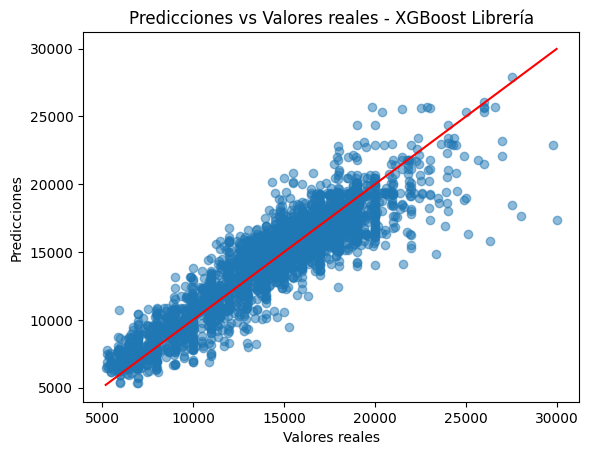

In [123]:
# Gráfica de dispersión entre valores reales y predicciones
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores reales - XGBoost Librería")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

<p style="text-align: justify;">
El gráfico de dispersión de predicciones vs valores reales muestra una correlación positiva. La línea roja representa las predicciones ideales, es decir el caso donde y_test = y_pred en todos los puntos. Como se observa en la gráfica, la mayoría de los puntos están cercanos a esta línea, lo que indica que el modelo realiza predicciones correctas. Se observa cierta dispersión creciente a medida que aumentan los valores de y_test, lo que podría indicar que el modelo tiene más dificultad en predecir los valores extremos (posiblemente debido a outliers o a una varianza mayor en esos rangos). En general, la forma alineada de los puntos con la línea roja indica un buen ajuste del modelo, lo cual es soportado por las métricas de desempeño. <p>

**Recomendaciones**
<p style="text-align: justify;">
Como recomendación, se sugiere aplicar un método de calibración de hiperparámetros con validación cruzada, como por ejemplo GridSearchCV o RandomizedSearchCV. Esto permitiría encontrar combinaciones óptimas de parámetros relevantes —como learning_rate— mejorando el desempeño del modelo. Además, el uso de validación cruzada contribuye a reducir el riesgo de sobreajuste (overfitting), al garantizar que el modelo generalice adecuadamente sobre distintos subconjuntos de datos.<p>

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Calibracion con GridSearchCV
# Definir la grilla de hiperparámetros
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "gamma": [0, 0.1, 0.3, 0.5, 1, 5],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0]
}
# Definir el modelo con eval_metric incluido
xgb = XGBRegressor(eval_metric="rmse")
# Definir el GridSearchCV
grid_search = GridSearchCV(
    xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0
)
# Ajustar el modelo sin early_stopping_rounds
grid_search.fit(X_train, y_train)

In [106]:
# Mejor modelo
best_model = grid_search.best_estimator_
# Mejor hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros: ", best_params)

Mejores hiperparámetros:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05}


In [107]:
# Predecir con el mejor modelo
y_pred_best = best_model.predict(X_test)
# Evaluación del modelo
MAE_XGBGridSearchCV = mean_absolute_error(y_test, y_pred_best)
RMSE_XGBGridSearchCV = np.sqrt(mean_squared_error(y_test, y_pred_best))
R2_XGBGridSearchCV = r2_score(y_test, y_pred_best)
# Resultados
print('MAE: ', f'{MAE_XGBGridSearchCV:.4f}')
print('RMSE: ', f'{RMSE_XGBGridSearchCV:.4f}')
print('R2: ', f'{R2_XGBGridSearchCV:.4f}')

MAE:  1136.5352
RMSE:  1545.6715
R2:  0.8438


**Procedimiento** <br>
<p style="text-align: justify;">
Se implementó GridSearchCV con validación cruzada para calibrar los hiperparámetros del modelo XGBRegressor. Se buscaron combinaciones óptimas de learning_rate, gamma y colsample_bytree, seleccionando el modelo con menor error cuadrático medio (RMSE) y evaluando su rendimiento sobre el set de prueba. <p>

**Relevancia de Parámetros Calibrados**
><p style="text-align: justify;">
>learning_rate: Establece la tasa de aprendizaje del modelo. Un valor bajo mejora la generalización pero requiere más árboles. Si es muy alto, puede causar sobreajuste o saltarse óptimos.<br><br>
>gamma: Define el umbral mínimo de mejora en la pérdida para que el árbol realice una partición. Valores altos lo hacen más conservador, ayudando a reducir sobreajuste pero también pudiendo limitar la capacidad predictiva.<br><br>
>colsample_bytree: Proporción de columnas utilizadas al construir cada árbol. Valores bajos introducen aleatoriedad, lo cual ayuda a evitar el sobreajuste; valores más altos permiten al modelo usar más información, lo cual puede ser útil si no hay mucha colinealidad.<p>

**Evaluación del Desempeño del Modelo**
<p style="text-align: justify;">
El modelo ajustado con GridSearchCV logró un MAE de 1136.5352 y un RMSE de 1545.6715, mejorando respecto al modelo del punto anterior. Estos valores indican que, en promedio, el error de predicción se redujo, y la menor diferencia entre MAE y RMSE sugiere que el modelo está manejando mejor los valores extremos. En conjunto con el R cuadrado (0.8438), el desempeño del modelo es bueno y está mejor calibrado que el modelo estimado inicialmente.<p>

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

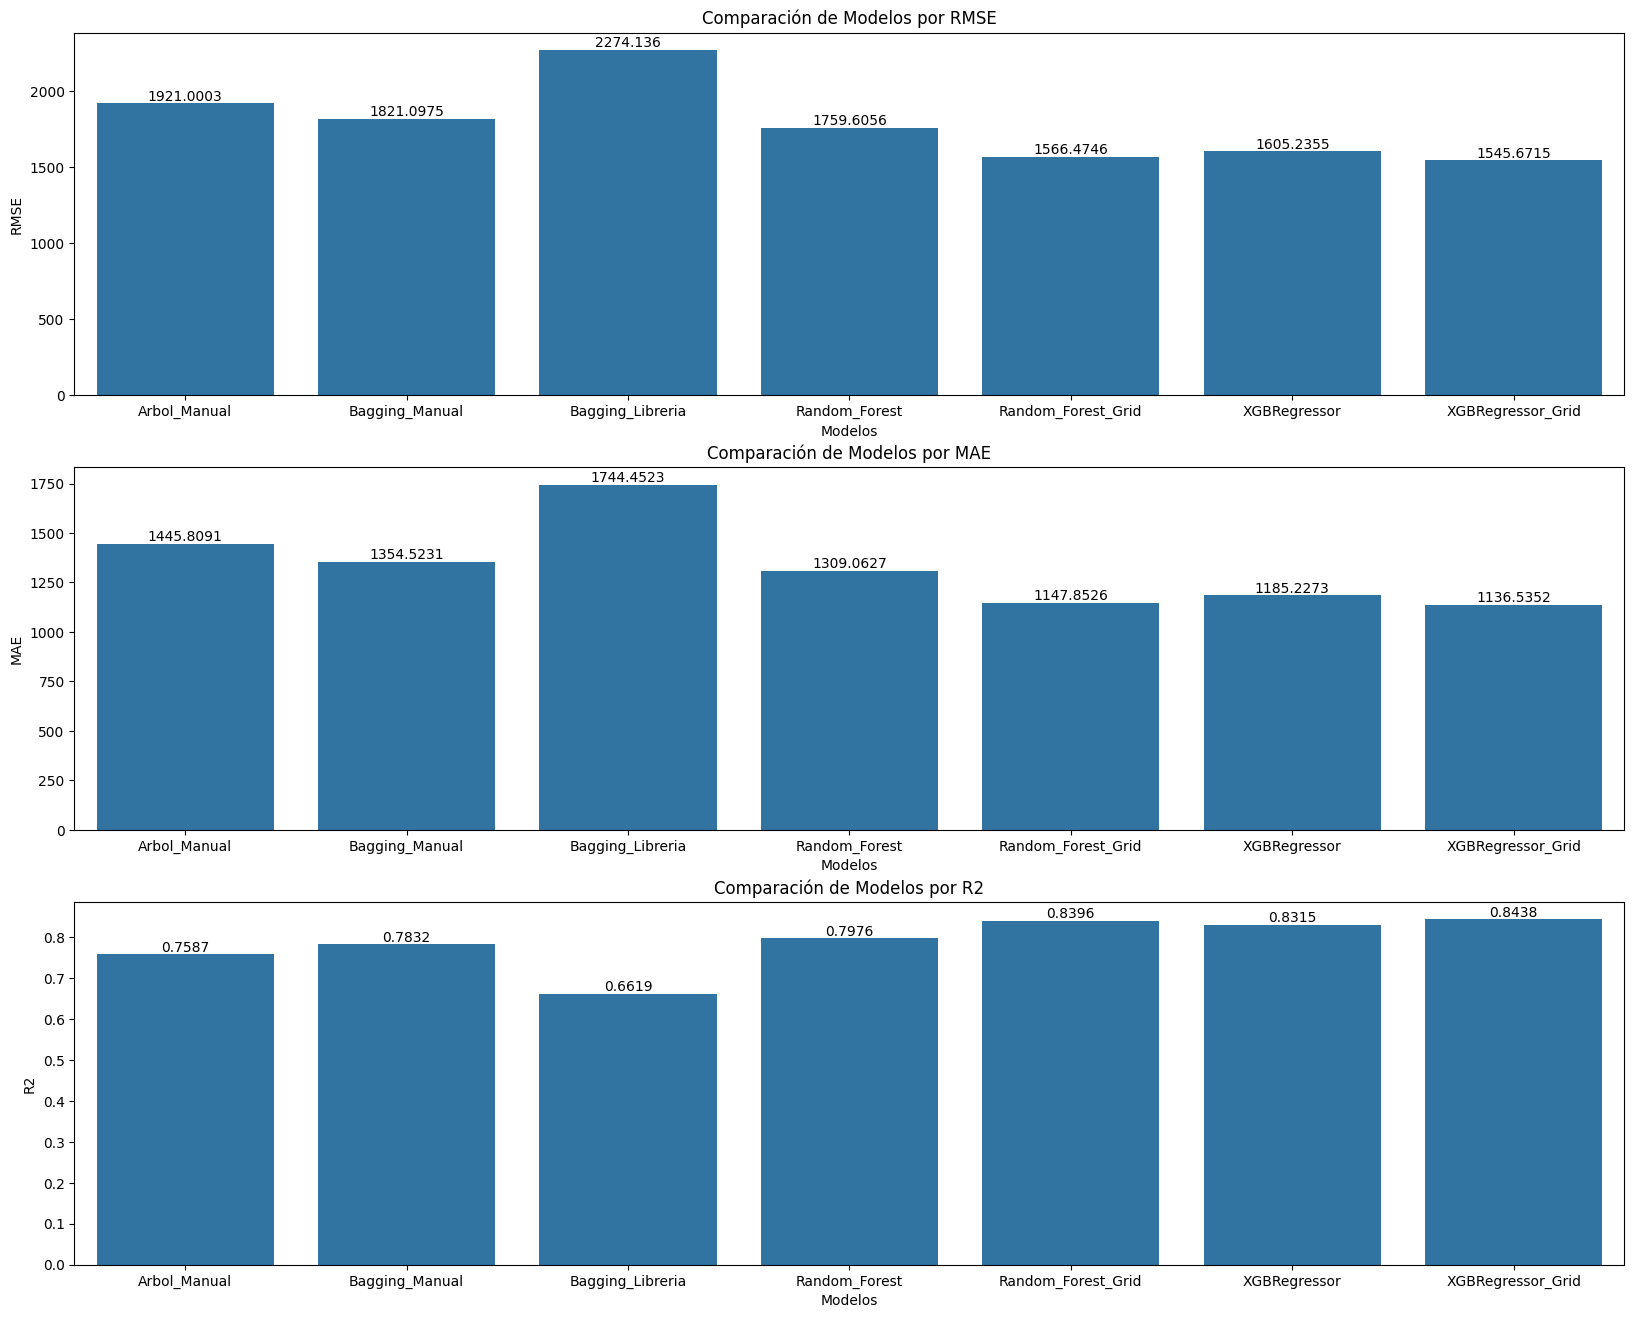

In [122]:
modelos = ['Arbol_Manual', 'Bagging_Manual', 'Bagging_Libreria', 'Random_Forest', 'Random_Forest_Grid', 'XGBRegressor', 'XGBRegressor_Grid']
RMSE = [RMSETREE, RMSE_BaggingManual, RMSE_BaggingLibreria, RMSE_RandomForest, RMSE_RandomForest_Grid, RMSE_XGBReg, RMSE_XGBGridSearchCV]
MAE = [MAETREE, MAE_BaggingManual, MAE_BaggingLibreria, MAE_Random_Forest, MAE_RandomForest_Grid, MAE_XGBReg, MAE_XGBGridSearchCV]
R2 = [R2Tree, R2_BaggingManual, R2_BaggingLibreria, R2_RandomForest, R2_RandomForest_Grid, R2_XGBReg, R2_XGBGridSearchCV]

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 16))

# Gráfico 1: Comparar modelos por RMSE
sns.barplot(x=modelos, y=RMSE, ax=axs[0])
axs[0].set_title('Comparación de Modelos por RMSE')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('RMSE')
for i in range(len(modelos)):
    axs[0].text(i, RMSE[i], round(RMSE[i], 4), ha='center', va='bottom')

# Gráfico 2: Comparar modelos por F1
sns.barplot(x=modelos, y=MAE, ax=axs[1])
axs[1].set_title('Comparación de Modelos por MAE')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('MAE')
for i in range(len(modelos)):
    axs[1].text(i, MAE[i], round(MAE[i], 4), ha='center', va='bottom')

# Gráfico 3: Comparar modelos por R2
sns.barplot(x=modelos, y=R2, ax=axs[2])
axs[2].set_title('Comparación de Modelos por R2')
axs[2].set_xlabel('Modelos')
axs[2].set_ylabel('R2')
for i in range(len(modelos)):
    axs[2].text(i, R2[i], round(R2[i], 4), ha='center', va='bottom')

<p style="text-align: justify;">
La gráfica anterior compara los resultados de los modelos comprando el RMSE, MAE y R². El modelo XGBRegressor_Grid se posiciona como el más eficaz, obteniendo el menor error (RMSE y MAE) y el mayor poder explicativo (R² de 0.8438). Le siguen el Random Forest con calibración de parámetros por GridSearchCV(Random_Forest_Grid) y XGBRegressor sin calibración de parámetros. En contraste, Bagging estimado con librería y con restricción de parámetros  muestra el peor desempeño, con errores significativamente más altos y un R² de apenas 0.4956. Las versiones manuales de los modelos tienen resultados aceptables, pero son superadas por las variantes optimizadas. Esto destaca la importancia de la selección cuidadosa y ajuste de hiperparámetros. <p>